# Quantum Pump Efficient Mapping via Bayesian Optimization

## Purpose: Efficient Pump Map, Pumping Curve, and Error Analysis

### Concept:
Instead of finding the optimum point, we use **Bayesian Optimization for efficient mapping**:
- **Traditional approach**: Measure on dense grid (e.g., 100×100 = 10,000 points)
- **BO approach**: Measure strategically selected points, then use GP to predict the full map

### Acquisition Strategy for Mapping:
- **Exploration-focused**: Maximize uncertainty (σ) to fill gaps in the map
- **Hybrid**: Combine uncertainty sampling with Latin Hypercube for coverage

### Outputs:
1. **Pump Map**: 2D map of ⟨n⟩ vs (V_ENT, V_EXIT) at fixed V_P
2. **Pumping Curves**: 1D curves of ⟨n⟩ vs V_EXIT at various V_ENT
3. **Error Analysis**: |δIp| vs V_EXIT with uncertainty bands

### Physics Model (Simulator):
$$n_{exit} = \exp\left[-\exp\left(-\frac{V-V_a}{V_b}\right)\right] + \exp\left[-\exp\left(-\frac{V-V_a+\delta_2}{V_b}\right)\right]$$

In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from pathlib import Path
from datetime import datetime
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import qmc  # Latin Hypercube Sampling

print('Quantum Pump Efficient Mapping v1')
print('='*50)

Quantum Pump Efficient Mapping v1


In [2]:
# Cell 2: Configuration

class MappingConfig:
    """Configuration for efficient pump mapping"""
    
    # ========== MAPPING PARAMETERS (ADJUST THESE!) ==========
    # Number of measurement points for mapping
    N_INITIAL_LHS = 30       # Initial Latin Hypercube samples
    N_ADAPTIVE = 70          # Adaptive uncertainty-based samples
    N_TOTAL = 100            # Total measurements (N_INITIAL_LHS + N_ADAPTIVE)
    
    # Fixed V_P for 2D mapping (V_ENT vs V_EXIT)
    V_P_FIXED = -0.63        # Center of plunger bathtub
    
    # Grid resolution for GP prediction (visualization)
    GRID_RESOLUTION = 80     # 80×80 prediction grid
    
    # Pumping curve parameters
    V_ENT_CURVES = [-0.68, -0.64, -0.60, -0.56]  # V_ENT values for curves
    N_CURVE_POINTS = 100     # Points per curve
    # =========================================================
    
    # Physical constants
    e = 1.602176634e-19
    f = 0.350540506e9
    
    @property
    def target_current(self):
        return self.e * self.f
    
    # Gate voltage bounds for 2D mapping (V_ENT, V_EXIT)
    bounds_2d = np.array([
        [-0.75, -0.50],  # V_ENT
        [-0.80, -0.50]   # V_EXIT
    ])
    
    # Output directory
    output_dir = Path('./mapping_outputs')
    
    @classmethod
    def print_settings(cls):
        print('='*60)
        print('MAPPING CONFIGURATION')
        print('='*60)
        print(f'Initial LHS samples:    {cls.N_INITIAL_LHS}')
        print(f'Adaptive samples:       {cls.N_ADAPTIVE}')
        print(f'Total measurements:     {cls.N_TOTAL}')
        print(f'Fixed V_P:              {cls.V_P_FIXED} V')
        print(f'Prediction grid:        {cls.GRID_RESOLUTION}×{cls.GRID_RESOLUTION}')
        print(f'Pumping curves at V_ENT: {cls.V_ENT_CURVES}')
        print('='*60)


MappingConfig.print_settings()

MAPPING CONFIGURATION
Initial LHS samples:    30
Adaptive samples:       70
Total measurements:     100
Fixed V_P:              -0.63 V
Prediction grid:        80×80
Pumping curves at V_ENT: [-0.68, -0.64, -0.6, -0.56]


In [3]:
# Cell 3: Physics Model (Experiment Simulator)

class PumpSimulator:
    """
    Physics-based pump simulator (acts as experiment proxy).
    V8 Optimized Model: Wide n=1 plateau, no n=0.5 plateau.
    """
    
    def __init__(self, noise_std=1e-4):
        # EXIT Gate Parameters
        self.Va_base = -0.66
        self.Vb = 0.008          # Sharp transitions
        self.delta2 = 0.10       # Wide n=1 plateau (100mV)
        self.cross_coupling_ent = 0.30
        self.V_ent_ref = -0.62
        
        # ENT Gate Parameters (Bathtub)
        self.V_ent_center = -0.62
        self.ent_width = 0.20
        self.ent_sharpness = 100.0
        
        # Plunger Gate Parameters (Bathtub)
        self.V_p_center = -0.63
        self.p_width = 0.20
        self.p_sharpness = 80.0
        
        # Measurement noise
        self.noise_std = noise_std
        
        print(f'PumpSimulator initialized (noise_std={noise_std})')
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def effective_Va(self, V_ent):
        return self.Va_base + self.cross_coupling_ent * (V_ent - self.V_ent_ref)
    
    def f_exit(self, V_exit, V_ent):
        Va_eff = self.effective_Va(V_ent)
        arg1 = np.clip(-(V_exit - Va_eff) / self.Vb, -100, 100)
        arg2 = np.clip(-(V_exit - Va_eff + self.delta2) / self.Vb, -100, 100)
        return np.exp(-np.exp(arg1)) + np.exp(-np.exp(arg2))
    
    def f_entrance(self, V_ent):
        V_L = self.V_ent_center - self.ent_width / 2
        V_R = self.V_ent_center + self.ent_width / 2
        return self.sigmoid(self.ent_sharpness * (V_ent - V_L)) * \
               self.sigmoid(-self.ent_sharpness * (V_ent - V_R))
    
    def f_plunger(self, V_p):
        V_L = self.V_p_center - self.p_width / 2
        V_R = self.V_p_center + self.p_width / 2
        return self.sigmoid(self.p_sharpness * (V_p - V_L)) * \
               self.sigmoid(-self.p_sharpness * (V_p - V_R))
    
    def measure(self, V_ent, V_p, V_exit, add_noise=True):
        """
        Simulate a single measurement.
        Returns n (electrons per cycle).
        """
        n = self.f_exit(V_exit, V_ent) * self.f_entrance(V_ent) * self.f_plunger(V_p)
        if add_noise:
            n += np.random.normal(0, self.noise_std)
        return n
    
    def measure_2d(self, V_ent, V_exit, V_p_fixed, add_noise=True):
        """
        Measure at (V_ent, V_exit) with fixed V_p.
        For 2D mapping.
        """
        return self.measure(V_ent, V_p_fixed, V_exit, add_noise)
    
    def ground_truth_map(self, V_ent_range, V_exit_range, V_p_fixed):
        """
        Generate ground truth map (no noise) for comparison.
        """
        V_ENT, V_EXIT = np.meshgrid(V_ent_range, V_exit_range)
        n_map = np.zeros_like(V_ENT)
        for i in range(len(V_exit_range)):
            for j in range(len(V_ent_range)):
                n_map[i, j] = self.measure(V_ENT[i, j], V_p_fixed, V_EXIT[i, j], add_noise=False)
        return V_ENT, V_EXIT, n_map


# Initialize simulator
simulator = PumpSimulator(noise_std=1e-4)

PumpSimulator initialized (noise_std=0.0001)


In [4]:
# Cell 4: Efficient Mapping Engine

class EfficientMapper:
    """
    Bayesian Optimization-based efficient mapping.
    Uses GP to predict full map from sparse measurements.
    """
    
    def __init__(self, bounds_2d, config):
        self.bounds = bounds_2d
        self.config = config
        
        # GP for n prediction
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.05, nu=2.5) + \
                      WhiteKernel(noise_level=1e-6)
        self.gp = GaussianProcessRegressor(
            kernel=self.kernel,
            n_restarts_optimizer=10,
            normalize_y=True
        )
        
        # Storage
        self.X_measured = []  # [V_ENT, V_EXIT]
        self.y_measured = []  # n values
        self.is_fitted = False
        
    def generate_initial_samples(self, n_samples):
        """
        Generate initial samples using Latin Hypercube Sampling.
        Ensures good coverage of the parameter space.
        """
        sampler = qmc.LatinHypercube(d=2, seed=42)
        samples = sampler.random(n=n_samples)
        
        # Scale to bounds
        lower = self.bounds[:, 0]
        upper = self.bounds[:, 1]
        scaled_samples = qmc.scale(samples, lower, upper)
        
        return scaled_samples
    
    def fit(self):
        """Fit GP to current measurements."""
        if len(self.X_measured) > 0:
            X = np.array(self.X_measured)
            y = np.array(self.y_measured)
            self.gp.fit(X, y)
            self.is_fitted = True
    
    def predict(self, X):
        """Predict n and uncertainty at points X."""
        if not self.is_fitted:
            return None, None
        X = np.atleast_2d(X)
        return self.gp.predict(X, return_std=True)
    
    def suggest_next_point(self, n_candidates=1000):
        """
        Suggest next measurement point based on maximum uncertainty.
        (Exploration-focused acquisition for mapping)
        """
        if not self.is_fitted:
            return None
        
        # Generate random candidates
        candidates = np.random.uniform(
            self.bounds[:, 0], self.bounds[:, 1],
            size=(n_candidates, 2)
        )
        
        # Predict uncertainty at candidates
        _, sigma = self.gp.predict(candidates, return_std=True)
        
        # Select point with maximum uncertainty
        best_idx = np.argmax(sigma)
        return candidates[best_idx]
    
    def add_measurement(self, x, y):
        """Add a measurement to the dataset."""
        self.X_measured.append(x)
        self.y_measured.append(y)
    
    def predict_map(self, V_ent_range, V_exit_range):
        """
        Predict full 2D map using GP.
        Returns: V_ENT grid, V_EXIT grid, n_mean, n_std
        """
        V_ENT, V_EXIT = np.meshgrid(V_ent_range, V_exit_range)
        X_grid = np.column_stack([V_ENT.ravel(), V_EXIT.ravel()])
        
        n_mean, n_std = self.gp.predict(X_grid, return_std=True)
        
        n_mean = n_mean.reshape(V_ENT.shape)
        n_std = n_std.reshape(V_ENT.shape)
        
        return V_ENT, V_EXIT, n_mean, n_std
    
    def predict_curve(self, V_exit_range, V_ent_fixed):
        """
        Predict pumping curve at fixed V_ENT.
        Returns: n_mean, n_std
        """
        X = np.column_stack([np.full_like(V_exit_range, V_ent_fixed), V_exit_range])
        return self.gp.predict(X, return_std=True)


print('EfficientMapper defined')

EfficientMapper defined


In [5]:
# Cell 5: Run Efficient Mapping

def run_efficient_mapping(simulator, config):
    """
    Execute efficient mapping using BO-based adaptive sampling.
    """
    print('='*60)
    print('EFFICIENT PUMP MAPPING')
    print('='*60)
    config.print_settings()
    
    # Initialize mapper
    mapper = EfficientMapper(config.bounds_2d, config)
    
    # Create output directory
    config.output_dir.mkdir(parents=True, exist_ok=True)
    
    # ===== Phase 1: Initial LHS Sampling =====
    print(f'\nPhase 1: Latin Hypercube Sampling ({config.N_INITIAL_LHS} points)')
    print('-'*60)
    
    initial_points = mapper.generate_initial_samples(config.N_INITIAL_LHS)
    
    for i, (V_ent, V_exit) in enumerate(initial_points):
        n = simulator.measure_2d(V_ent, V_exit, config.V_P_FIXED)
        mapper.add_measurement([V_ent, V_exit], n)
        
        if (i + 1) % 10 == 0:
            print(f'  LHS {i+1:3d}/{config.N_INITIAL_LHS}: '
                  f'V_ENT={V_ent:.3f}V, V_EXIT={V_exit:.3f}V, n={n:.4f}')
    
    mapper.fit()
    print(f'  Initial GP fitted with {len(mapper.X_measured)} points')
    
    # ===== Phase 2: Adaptive Uncertainty Sampling =====
    print(f'\nPhase 2: Adaptive Uncertainty Sampling ({config.N_ADAPTIVE} points)')
    print('-'*60)
    
    for i in range(config.N_ADAPTIVE):
        # Suggest next point (max uncertainty)
        next_point = mapper.suggest_next_point()
        V_ent, V_exit = next_point
        
        # Measure
        n = simulator.measure_2d(V_ent, V_exit, config.V_P_FIXED)
        mapper.add_measurement([V_ent, V_exit], n)
        
        # Refit GP
        mapper.fit()
        
        if (i + 1) % 10 == 0:
            # Calculate current map uncertainty
            V_ent_test = np.linspace(config.bounds_2d[0, 0], config.bounds_2d[0, 1], 20)
            V_exit_test = np.linspace(config.bounds_2d[1, 0], config.bounds_2d[1, 1], 20)
            _, _, _, sigma_map = mapper.predict_map(V_ent_test, V_exit_test)
            mean_sigma = np.mean(sigma_map)
            
            print(f'  Adaptive {i+1:3d}/{config.N_ADAPTIVE}: '
                  f'V_ENT={V_ent:.3f}V, V_EXIT={V_exit:.3f}V, '
                  f'n={n:.4f}, mean_σ={mean_sigma:.4f}')
    
    print(f'\nMapping complete: {len(mapper.X_measured)} total measurements')
    print('='*60)
    
    return mapper


# Run mapping
config = MappingConfig()
mapper = run_efficient_mapping(simulator, config)

EFFICIENT PUMP MAPPING
MAPPING CONFIGURATION
Initial LHS samples:    30
Adaptive samples:       70
Total measurements:     100
Fixed V_P:              -0.63 V
Prediction grid:        80×80
Pumping curves at V_ENT: [-0.68, -0.64, -0.6, -0.56]

Phase 1: Latin Hypercube Sampling (30 points)
------------------------------------------------------------
  LHS  10/30: V_ENT=-0.749V, V_EXIT=-0.546V, n=0.1087
  LHS  20/30: V_ENT=-0.535V, V_EXIT=-0.677V, n=0.8197
  LHS  30/30: V_ENT=-0.693V, V_EXIT=-0.511V, n=1.8747
  Initial GP fitted with 30 points

Phase 2: Adaptive Uncertainty Sampling (70 points)
------------------------------------------------------------
  Adaptive  10/70: V_ENT=-0.501V, V_EXIT=-0.685V, n=0.1290, mean_σ=0.1225
  Adaptive  20/70: V_ENT=-0.598V, V_EXIT=-0.800V, n=-0.0002, mean_σ=0.1677
  Adaptive  30/70: V_ENT=-0.500V, V_EXIT=-0.544V, n=0.2441, mean_σ=0.0782
  Adaptive  40/70: V_ENT=-0.518V, V_EXIT=-0.710V, n=0.4121, mean_σ=0.0618
  Adaptive  50/70: V_ENT=-0.526V, V_EXIT=-0

In [6]:
# Cell 6: Generate and Compare Maps

def generate_maps(mapper, simulator, config):
    """
    Generate GP-predicted map and ground truth for comparison.
    """
    res = config.GRID_RESOLUTION
    V_ent_range = np.linspace(config.bounds_2d[0, 0], config.bounds_2d[0, 1], res)
    V_exit_range = np.linspace(config.bounds_2d[1, 0], config.bounds_2d[1, 1], res)
    
    # GP prediction
    V_ENT, V_EXIT, n_gp_mean, n_gp_std = mapper.predict_map(V_ent_range, V_exit_range)
    
    # Ground truth
    _, _, n_truth = simulator.ground_truth_map(V_ent_range, V_exit_range, config.V_P_FIXED)
    
    # Prediction error
    prediction_error = np.abs(n_gp_mean - n_truth)
    
    return {
        'V_ENT': V_ENT,
        'V_EXIT': V_EXIT,
        'n_gp_mean': n_gp_mean,
        'n_gp_std': n_gp_std,
        'n_truth': n_truth,
        'error': prediction_error
    }


maps = generate_maps(mapper, simulator, config)
print(f'Maps generated: {config.GRID_RESOLUTION}×{config.GRID_RESOLUTION} grid')
print(f'Mean prediction error: {np.mean(maps["error"]):.4f}')
print(f'Max prediction error:  {np.max(maps["error"]):.4f}')
print(f'Mean GP uncertainty:   {np.mean(maps["n_gp_std"]):.4f}')

Maps generated: 80×80 grid
Mean prediction error: 0.0444
Max prediction error:  0.2342
Mean GP uncertainty:   0.0383


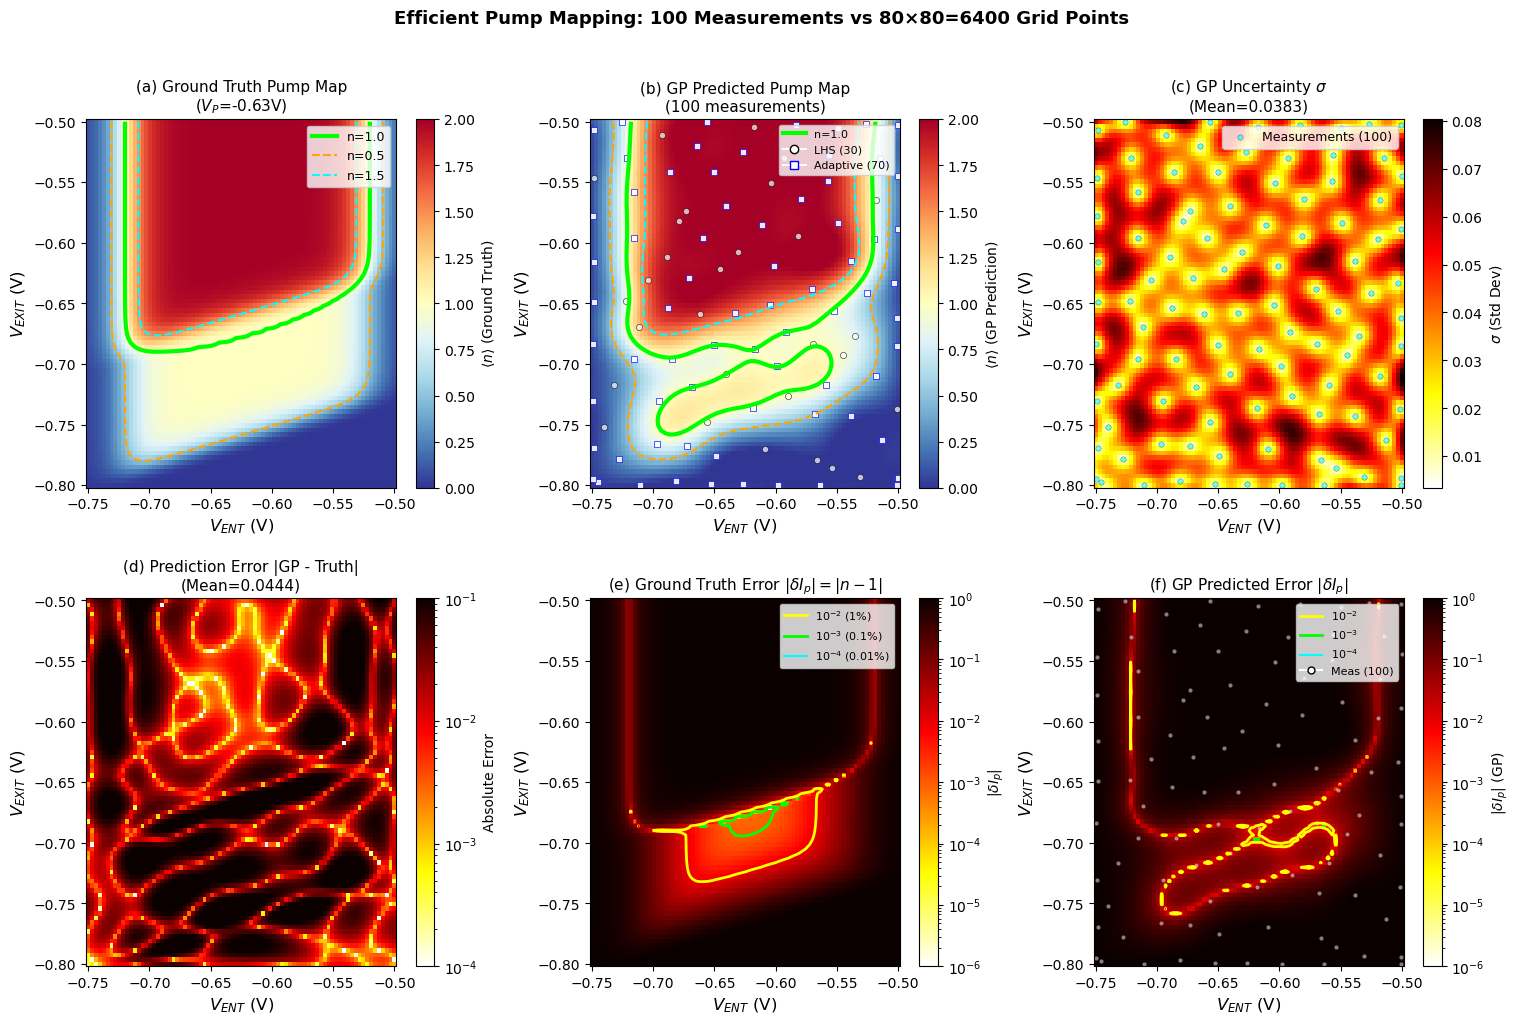

Saved: mapping_outputs/pump_maps.png


In [7]:
# Cell 7: Visualization - Pump Maps (6 Panels)

def plot_pump_maps(maps, mapper, config):
    """
    6-panel pump map visualization with full legends.
    """
    fig = plt.figure(figsize=(18, 11))
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
    
    X_meas = np.array(mapper.X_measured)
    n_meas = len(X_meas)
    
    # ===== (a) Ground Truth Pump Map =====
    ax1 = fig.add_subplot(gs[0, 0])
    cm1 = ax1.pcolormesh(maps['V_ENT'], maps['V_EXIT'], maps['n_truth'],
                         cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    cs1 = ax1.contour(maps['V_ENT'], maps['V_EXIT'], maps['n_truth'],
                      levels=[0.5, 1.0, 1.5], colors=['orange', 'lime', 'cyan'],
                      linewidths=[1.5, 3, 1.5], linestyles=['--', '-', '--'])
    
    ax1.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax1.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax1.set_title(f'(a) Ground Truth Pump Map\n($V_P$={config.V_P_FIXED}V)', fontsize=11)
    
    legend_elements_1 = [
        Line2D([0], [0], color='lime', lw=3, label='n=1.0'),
        Line2D([0], [0], color='orange', lw=1.5, ls='--', label='n=0.5'),
        Line2D([0], [0], color='cyan', lw=1.5, ls='--', label='n=1.5')
    ]
    ax1.legend(handles=legend_elements_1, fontsize=9, loc='upper right')
    cbar1 = plt.colorbar(cm1, ax=ax1)
    cbar1.set_label(r'$\langle n \rangle$ (Ground Truth)', fontsize=10)
    
    # ===== (b) GP Predicted Pump Map =====
    ax2 = fig.add_subplot(gs[0, 1])
    cm2 = ax2.pcolormesh(maps['V_ENT'], maps['V_EXIT'], maps['n_gp_mean'],
                         cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    cs2 = ax2.contour(maps['V_ENT'], maps['V_EXIT'], maps['n_gp_mean'],
                      levels=[0.5, 1.0, 1.5], colors=['orange', 'lime', 'cyan'],
                      linewidths=[1.5, 3, 1.5], linestyles=['--', '-', '--'])
    
    # Measurement points
    ax2.scatter(X_meas[:config.N_INITIAL_LHS, 0], X_meas[:config.N_INITIAL_LHS, 1],
                c='white', s=20, alpha=0.7, edgecolors='k', linewidths=0.5,
                label=f'LHS ({config.N_INITIAL_LHS})')
    ax2.scatter(X_meas[config.N_INITIAL_LHS:, 0], X_meas[config.N_INITIAL_LHS:, 1],
                c='white', s=20, alpha=0.9, edgecolors='blue', linewidths=0.5, marker='s',
                label=f'Adaptive ({config.N_ADAPTIVE})')
    
    ax2.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax2.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax2.set_title(f'(b) GP Predicted Pump Map\n({n_meas} measurements)', fontsize=11)
    
    legend_elements_2 = [
        Line2D([0], [0], color='lime', lw=3, label='n=1.0'),
        Line2D([0], [0], marker='o', color='w', mfc='white', mec='k', ms=6,
               label=f'LHS ({config.N_INITIAL_LHS})'),
        Line2D([0], [0], marker='s', color='w', mfc='white', mec='blue', ms=6,
               label=f'Adaptive ({config.N_ADAPTIVE})')
    ]
    ax2.legend(handles=legend_elements_2, fontsize=8, loc='upper right')
    cbar2 = plt.colorbar(cm2, ax=ax2)
    cbar2.set_label(r'$\langle n \rangle$ (GP Prediction)', fontsize=10)
    
    # ===== (c) GP Uncertainty (σ) =====
    ax3 = fig.add_subplot(gs[0, 2])
    cm3 = ax3.pcolormesh(maps['V_ENT'], maps['V_EXIT'], maps['n_gp_std'],
                         cmap='hot_r', shading='auto')
    
    ax3.scatter(X_meas[:, 0], X_meas[:, 1], c='cyan', s=15, alpha=0.6,
                edgecolors='k', linewidths=0.3, label=f'Measurements ({n_meas})')
    
    ax3.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax3.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax3.set_title(f'(c) GP Uncertainty $\sigma$\n(Mean={np.mean(maps["n_gp_std"]):.4f})', fontsize=11)
    
    ax3.legend(fontsize=9, loc='upper right')
    cbar3 = plt.colorbar(cm3, ax=ax3)
    cbar3.set_label(r'$\sigma$ (Std Dev)', fontsize=10)
    
    # ===== (d) Prediction Error =====
    ax4 = fig.add_subplot(gs[1, 0])
    cm4 = ax4.pcolormesh(maps['V_ENT'], maps['V_EXIT'], maps['error'],
                         cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-4, vmax=1e-1))
    
    ax4.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax4.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax4.set_title(f'(d) Prediction Error |GP - Truth|\n(Mean={np.mean(maps["error"]):.4f})', fontsize=11)
    
    cbar4 = plt.colorbar(cm4, ax=ax4)
    cbar4.set_label('Absolute Error', fontsize=10)
    
    # ===== (e) Ground Truth Error Map |n-1| =====
    ax5 = fig.add_subplot(gs[1, 1])
    delta_truth = np.clip(np.abs(maps['n_truth'] - 1), 1e-10, None)
    cm5 = ax5.pcolormesh(maps['V_ENT'], maps['V_EXIT'], delta_truth,
                         cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-6, vmax=1))
    cs5 = ax5.contour(maps['V_ENT'], maps['V_EXIT'], delta_truth,
                      levels=[1e-4, 1e-3, 1e-2], colors=['cyan', 'lime', 'yellow'],
                      linewidths=[1.5, 2, 2])
    
    ax5.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax5.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax5.set_title(r'(e) Ground Truth Error $|\delta I_p|=|n-1|$', fontsize=11)
    
    legend_elements_5 = [
        Line2D([0], [0], color='yellow', lw=2, label=r'$10^{-2}$ (1%)'),
        Line2D([0], [0], color='lime', lw=2, label=r'$10^{-3}$ (0.1%)'),
        Line2D([0], [0], color='cyan', lw=1.5, label=r'$10^{-4}$ (0.01%)')
    ]
    ax5.legend(handles=legend_elements_5, fontsize=8, loc='upper right')
    cbar5 = plt.colorbar(cm5, ax=ax5)
    cbar5.set_label(r'$|\delta I_p|$', fontsize=10)
    
    # ===== (f) GP Predicted Error Map |n-1| =====
    ax6 = fig.add_subplot(gs[1, 2])
    delta_gp = np.clip(np.abs(maps['n_gp_mean'] - 1), 1e-10, None)
    cm6 = ax6.pcolormesh(maps['V_ENT'], maps['V_EXIT'], delta_gp,
                         cmap='hot_r', shading='auto',
                         norm=LogNorm(vmin=1e-6, vmax=1))
    cs6 = ax6.contour(maps['V_ENT'], maps['V_EXIT'], delta_gp,
                      levels=[1e-4, 1e-3, 1e-2], colors=['cyan', 'lime', 'yellow'],
                      linewidths=[1.5, 2, 2])
    
    ax6.scatter(X_meas[:, 0], X_meas[:, 1], c='white', s=10, alpha=0.5,
                edgecolors='k', linewidths=0.3)
    
    ax6.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax6.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax6.set_title(r'(f) GP Predicted Error $|\delta I_p|$', fontsize=11)
    
    legend_elements_6 = [
        Line2D([0], [0], color='yellow', lw=2, label=r'$10^{-2}$'),
        Line2D([0], [0], color='lime', lw=2, label=r'$10^{-3}$'),
        Line2D([0], [0], color='cyan', lw=1.5, label=r'$10^{-4}$'),
        Line2D([0], [0], marker='o', color='w', mfc='white', mec='k', ms=5,
               label=f'Meas ({n_meas})')
    ]
    ax6.legend(handles=legend_elements_6, fontsize=8, loc='upper right')
    cbar6 = plt.colorbar(cm6, ax=ax6)
    cbar6.set_label(r'$|\delta I_p|$ (GP)', fontsize=10)
    
    plt.suptitle(f'Efficient Pump Mapping: {n_meas} Measurements vs '
                 f'{config.GRID_RESOLUTION}×{config.GRID_RESOLUTION}={config.GRID_RESOLUTION**2} Grid Points',
                 fontsize=13, fontweight='bold')
    
    plt.savefig(config.output_dir / 'pump_maps.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Saved: {config.output_dir}/pump_maps.png')
    return fig


fig_maps = plot_pump_maps(maps, mapper, config)

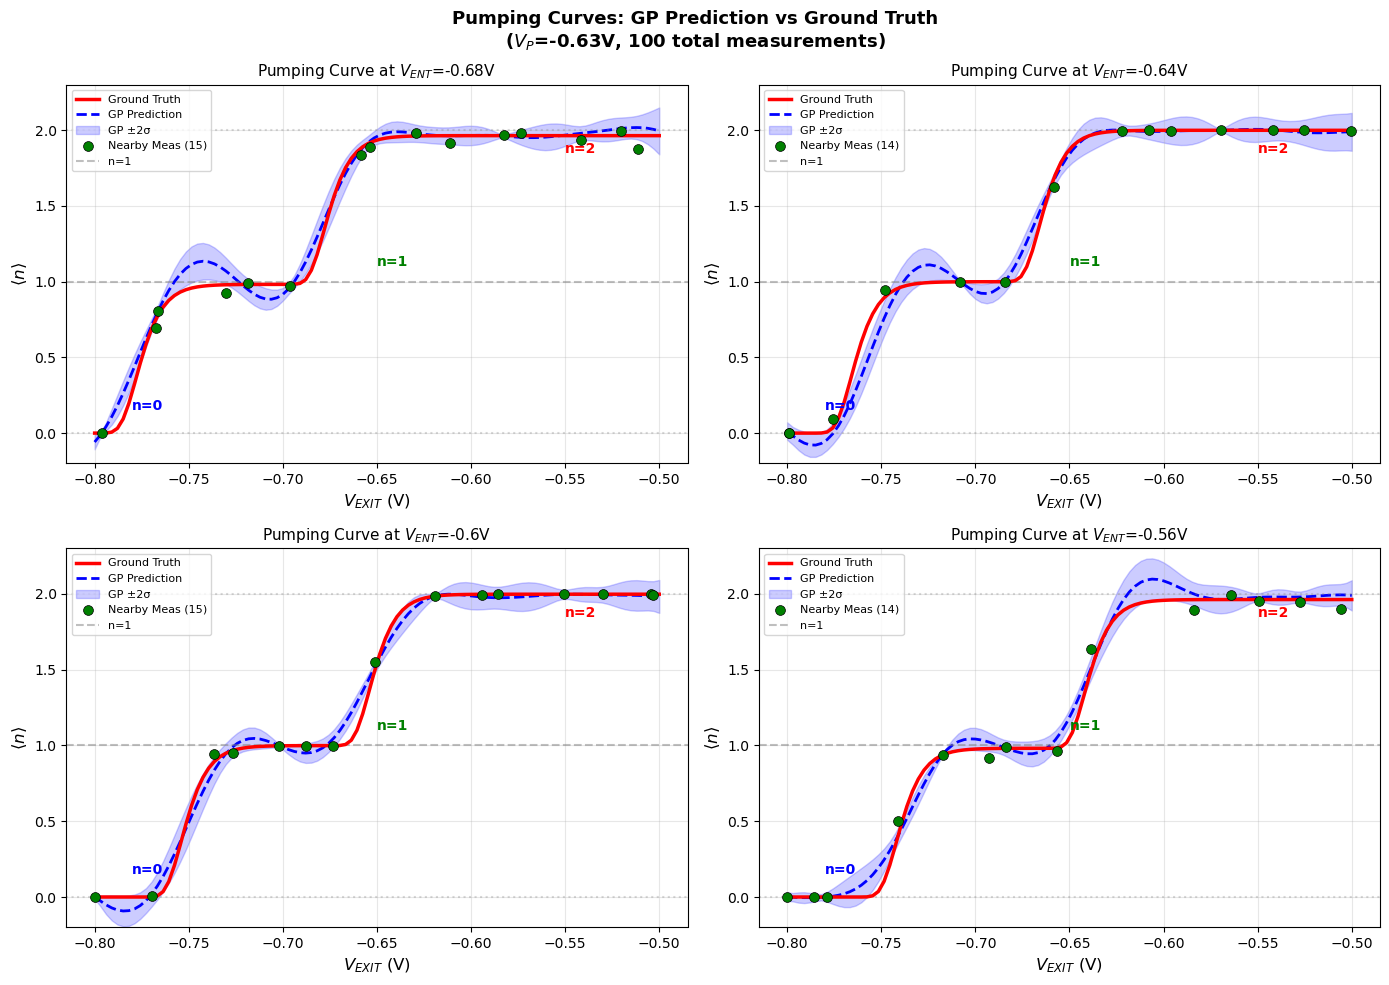

Saved: mapping_outputs/pumping_curves.png


In [8]:
# Cell 8: Pumping Curves

def plot_pumping_curves(mapper, simulator, config):
    """
    Plot pumping curves (n vs V_EXIT) at various V_ENT values.
    Compare GP prediction with ground truth.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    V_exit_range = np.linspace(config.bounds_2d[1, 0], config.bounds_2d[1, 1],
                               config.N_CURVE_POINTS)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(config.V_ENT_CURVES)))
    
    X_meas = np.array(mapper.X_measured)
    y_meas = np.array(mapper.y_measured)
    
    for idx, V_ent in enumerate(config.V_ENT_CURVES):
        ax = axes[idx]
        color = colors[idx]
        
        # Ground truth
        n_truth = np.array([simulator.measure_2d(V_ent, v_exit, config.V_P_FIXED, add_noise=False)
                           for v_exit in V_exit_range])
        
        # GP prediction
        n_gp, sigma_gp = mapper.predict_curve(V_exit_range, V_ent)
        
        # Plot
        ax.plot(V_exit_range, n_truth, 'r-', lw=2.5, label='Ground Truth', zorder=3)
        ax.plot(V_exit_range, n_gp, 'b--', lw=2, label='GP Prediction', zorder=2)
        ax.fill_between(V_exit_range, n_gp - 2*sigma_gp, n_gp + 2*sigma_gp,
                        color='blue', alpha=0.2, label='GP ±2σ')
        
        # Nearby measurements
        near_mask = np.abs(X_meas[:, 0] - V_ent) < 0.02  # ±20mV
        if np.any(near_mask):
            ax.scatter(X_meas[near_mask, 1], y_meas[near_mask],
                      c='green', s=50, edgecolors='k', linewidths=0.5, zorder=5,
                      label=f'Nearby Meas ({np.sum(near_mask)})')
        
        # Reference lines
        ax.axhline(1, color='gray', ls='--', alpha=0.5, label='n=1')
        ax.axhline(0, color='gray', ls=':', alpha=0.3)
        ax.axhline(2, color='gray', ls=':', alpha=0.3)
        
        # Labels
        ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
        ax.set_ylabel(r'$\langle n \rangle$', fontsize=12)
        ax.set_title(f'Pumping Curve at $V_{{ENT}}$={V_ent}V', fontsize=11)
        ax.legend(fontsize=8, loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.2, 2.3)
        
        # Region labels
        ax.text(config.bounds_2d[1, 0] + 0.02, 0.15, 'n=0', fontsize=10,
                fontweight='bold', color='blue')
        ax.text(config.bounds_2d[1, 0] + 0.15, 1.1, 'n=1', fontsize=10,
                fontweight='bold', color='green')
        ax.text(config.bounds_2d[1, 1] - 0.05, 1.85, 'n=2', fontsize=10,
                fontweight='bold', color='red')
    
    plt.suptitle(f'Pumping Curves: GP Prediction vs Ground Truth\n'
                 f'($V_P$={config.V_P_FIXED}V, {len(mapper.X_measured)} total measurements)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig(config.output_dir / 'pumping_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Saved: {config.output_dir}/pumping_curves.png')
    return fig


fig_curves = plot_pumping_curves(mapper, simulator, config)

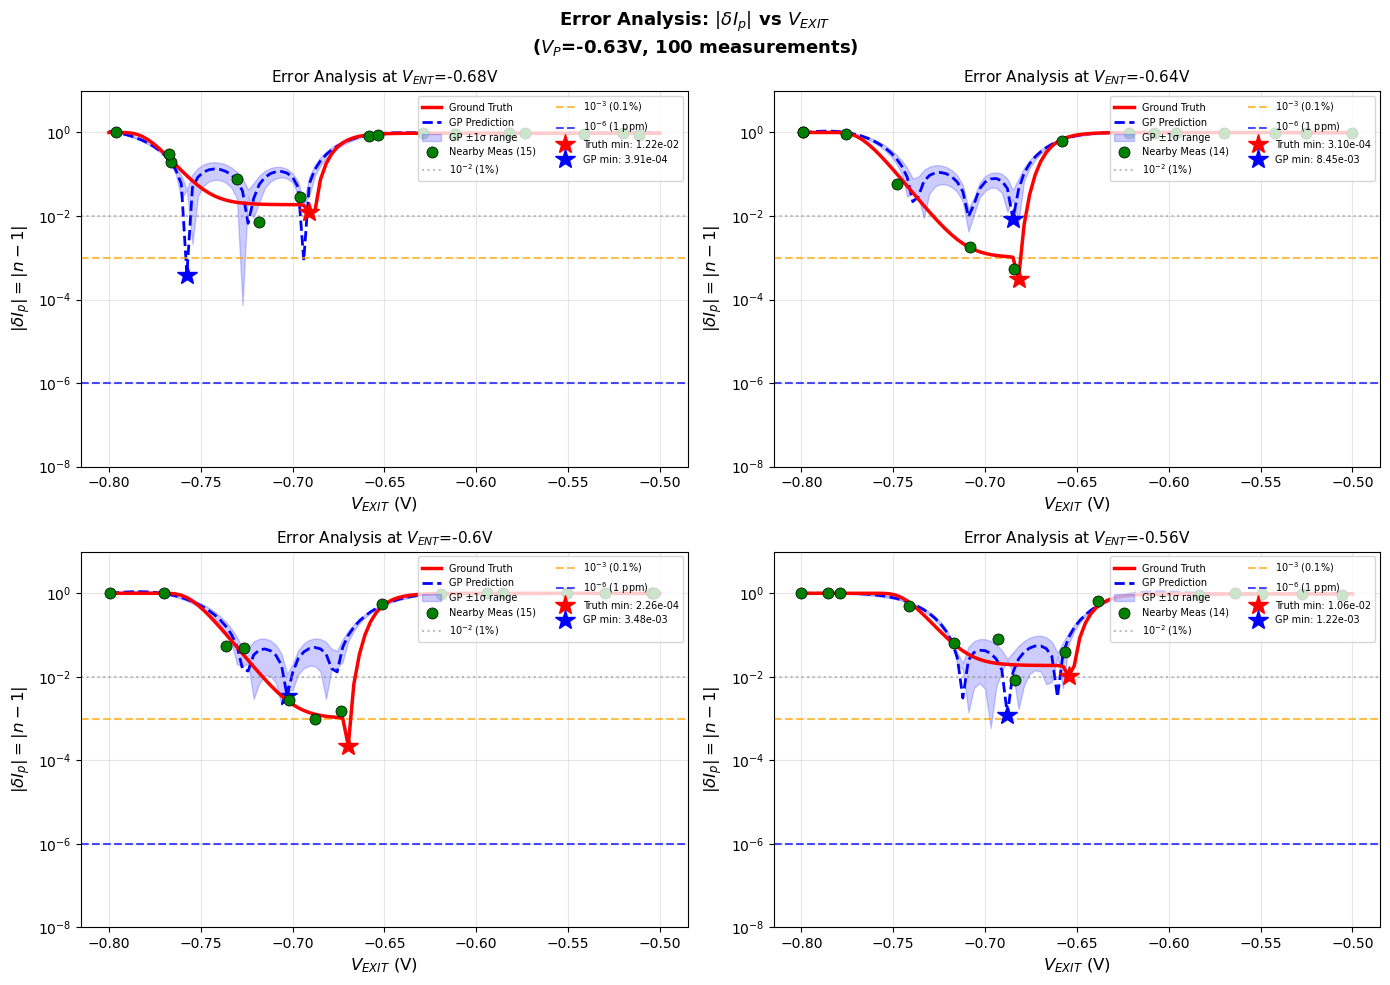

Saved: mapping_outputs/error_analysis.png


In [9]:
# Cell 9: Error Analysis

def plot_error_analysis(mapper, simulator, config):
    """
    Error analysis: |δIp| vs V_EXIT at various V_ENT.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    V_exit_range = np.linspace(config.bounds_2d[1, 0], config.bounds_2d[1, 1],
                               config.N_CURVE_POINTS)
    
    X_meas = np.array(mapper.X_measured)
    y_meas = np.array(mapper.y_measured)
    
    for idx, V_ent in enumerate(config.V_ENT_CURVES):
        ax = axes[idx]
        
        # Ground truth error
        n_truth = np.array([simulator.measure_2d(V_ent, v_exit, config.V_P_FIXED, add_noise=False)
                           for v_exit in V_exit_range])
        delta_truth = np.clip(np.abs(n_truth - 1), 1e-12, None)
        
        # GP prediction error
        n_gp, sigma_gp = mapper.predict_curve(V_exit_range, V_ent)
        delta_gp = np.clip(np.abs(n_gp - 1), 1e-12, None)
        
        # Uncertainty propagation (approximate)
        delta_gp_upper = np.clip(np.abs(n_gp + sigma_gp - 1), 1e-12, None)
        delta_gp_lower = np.clip(np.abs(n_gp - sigma_gp - 1), 1e-12, None)
        
        # Plot
        ax.semilogy(V_exit_range, delta_truth, 'r-', lw=2.5, label='Ground Truth', zorder=3)
        ax.semilogy(V_exit_range, delta_gp, 'b--', lw=2, label='GP Prediction', zorder=2)
        ax.fill_between(V_exit_range,
                        np.minimum(delta_gp_lower, delta_gp_upper),
                        np.maximum(delta_gp_lower, delta_gp_upper),
                        color='blue', alpha=0.2, label='GP ±1σ range')
        
        # Nearby measurements
        near_mask = np.abs(X_meas[:, 0] - V_ent) < 0.02
        if np.any(near_mask):
            delta_meas = np.abs(y_meas[near_mask] - 1)
            ax.semilogy(X_meas[near_mask, 1], delta_meas, 'go', ms=8,
                       mec='k', mew=0.5, label=f'Nearby Meas ({np.sum(near_mask)})', zorder=5)
        
        # Reference lines
        ax.axhline(1e-2, color='gray', ls=':', alpha=0.5, label=r'$10^{-2}$ (1%)')
        ax.axhline(1e-3, color='orange', ls='--', lw=1.5, alpha=0.7, label=r'$10^{-3}$ (0.1%)')
        ax.axhline(1e-6, color='blue', ls='--', lw=1.5, alpha=0.7, label=r'$10^{-6}$ (1 ppm)')
        
        # Find minimum
        min_idx_truth = np.argmin(delta_truth)
        min_idx_gp = np.argmin(delta_gp)
        ax.plot(V_exit_range[min_idx_truth], delta_truth[min_idx_truth], 'r*', ms=15,
                label=f'Truth min: {delta_truth[min_idx_truth]:.2e}')
        ax.plot(V_exit_range[min_idx_gp], delta_gp[min_idx_gp], 'b*', ms=15,
                label=f'GP min: {delta_gp[min_idx_gp]:.2e}')
        
        ax.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
        ax.set_ylabel(r'$|\delta I_p| = |n - 1|$', fontsize=12)
        ax.set_title(f'Error Analysis at $V_{{ENT}}$={V_ent}V', fontsize=11)
        ax.legend(fontsize=7, loc='upper right', ncol=2)
        ax.grid(True, alpha=0.3, which='both')
        ax.set_ylim(1e-8, 1e1)
    
    plt.suptitle(f'Error Analysis: $|\delta I_p|$ vs $V_{{EXIT}}$\n'
                 f'($V_P$={config.V_P_FIXED}V, {len(mapper.X_measured)} measurements)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig(config.output_dir / 'error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Saved: {config.output_dir}/error_analysis.png')
    return fig


fig_error = plot_error_analysis(mapper, simulator, config)

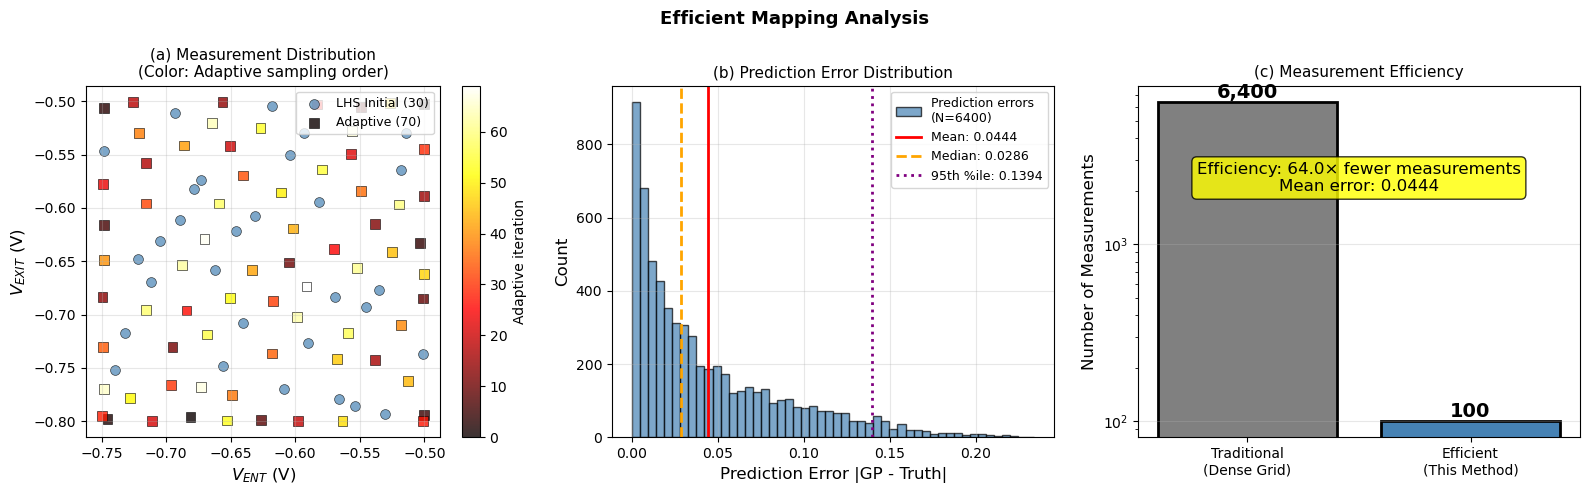

Saved: mapping_outputs/mapping_efficiency.png

MAPPING EFFICIENCY SUMMARY
Traditional dense grid:     6,400 measurements
Efficient mapping:          100 measurements
Efficiency gain:            64.0× fewer measurements
Mean prediction error:      0.0444
Median prediction error:    0.0286
95th percentile error:      0.1394


In [10]:
# Cell 10: Mapping Efficiency Analysis

def plot_mapping_efficiency(mapper, maps, config):
    """
    Analyze mapping efficiency: measurements vs accuracy.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    X_meas = np.array(mapper.X_measured)
    n_meas = len(X_meas)
    grid_points = config.GRID_RESOLUTION ** 2
    
    # ===== (a) Measurement Distribution =====
    ax = axes[0]
    
    # LHS points
    ax.scatter(X_meas[:config.N_INITIAL_LHS, 0], X_meas[:config.N_INITIAL_LHS, 1],
               c='steelblue', s=50, alpha=0.7, edgecolors='k', linewidths=0.5,
               label=f'LHS Initial ({config.N_INITIAL_LHS})')
    
    # Adaptive points
    adaptive_colors = np.arange(config.N_ADAPTIVE)
    sc = ax.scatter(X_meas[config.N_INITIAL_LHS:, 0], X_meas[config.N_INITIAL_LHS:, 1],
                    c=adaptive_colors, cmap='hot', s=50, alpha=0.8,
                    edgecolors='k', linewidths=0.5, marker='s',
                    label=f'Adaptive ({config.N_ADAPTIVE})')
    
    ax.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax.set_title('(a) Measurement Distribution\n(Color: Adaptive sampling order)', fontsize=11)
    ax.legend(fontsize=9, loc='upper right')
    plt.colorbar(sc, ax=ax, label='Adaptive iteration')
    ax.grid(True, alpha=0.3)
    
    # ===== (b) Error Histogram =====
    ax = axes[1]
    
    error_flat = maps['error'].flatten()
    ax.hist(error_flat, bins=50, color='steelblue', edgecolor='k', alpha=0.7,
            label=f'Prediction errors\n(N={len(error_flat)})')
    
    mean_err = np.mean(error_flat)
    median_err = np.median(error_flat)
    p95_err = np.percentile(error_flat, 95)
    
    ax.axvline(mean_err, color='red', ls='-', lw=2, label=f'Mean: {mean_err:.4f}')
    ax.axvline(median_err, color='orange', ls='--', lw=2, label=f'Median: {median_err:.4f}')
    ax.axvline(p95_err, color='purple', ls=':', lw=2, label=f'95th %ile: {p95_err:.4f}')
    
    ax.set_xlabel('Prediction Error |GP - Truth|', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('(b) Prediction Error Distribution', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # ===== (c) Efficiency Summary =====
    ax = axes[2]
    
    categories = ['Traditional\n(Dense Grid)', 'Efficient\n(This Method)']
    measurements = [grid_points, n_meas]
    colors = ['gray', 'steelblue']
    
    bars = ax.bar(categories, measurements, color=colors, edgecolor='k', linewidth=2)
    
    ax.set_ylabel('Number of Measurements', fontsize=12)
    ax.set_title('(c) Measurement Efficiency', fontsize=11)
    
    # Annotations
    for bar, meas in zip(bars, measurements):
        ax.annotate(f'{meas:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Efficiency ratio
    efficiency = grid_points / n_meas
    ax.annotate(f'Efficiency: {efficiency:.1f}× fewer measurements\n'
                f'Mean error: {mean_err:.4f}',
                xy=(0.5, 0.7), xycoords='axes fraction',
                ha='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Efficient Mapping Analysis', fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig(config.output_dir / 'mapping_efficiency.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Saved: {config.output_dir}/mapping_efficiency.png')
    
    # Print summary
    print('\n' + '='*60)
    print('MAPPING EFFICIENCY SUMMARY')
    print('='*60)
    print(f'Traditional dense grid:     {grid_points:,} measurements')
    print(f'Efficient mapping:          {n_meas:,} measurements')
    print(f'Efficiency gain:            {efficiency:.1f}× fewer measurements')
    print(f'Mean prediction error:      {mean_err:.4f}')
    print(f'Median prediction error:    {median_err:.4f}')
    print(f'95th percentile error:      {p95_err:.4f}')
    print('='*60)
    
    return fig


fig_efficiency = plot_mapping_efficiency(mapper, maps, config)

In [11]:
# Cell 11: Save Data to CSV

def save_data(mapper, maps, config):
    """
    Save all data to CSV files.
    """
    output_dir = config.output_dir
    
    # 1. Measurement data
    X_meas = np.array(mapper.X_measured)
    y_meas = np.array(mapper.y_measured)
    
    meas_df = pd.DataFrame({
        'V_ENT': X_meas[:, 0],
        'V_EXIT': X_meas[:, 1],
        'n_measured': y_meas,
        'phase': ['LHS'] * config.N_INITIAL_LHS + ['Adaptive'] * config.N_ADAPTIVE
    })
    meas_df.to_csv(output_dir / 'measurements.csv', index=False)
    print(f'Saved: {output_dir}/measurements.csv ({len(meas_df)} rows)')
    
    # 2. GP predicted map
    V_ENT_flat = maps['V_ENT'].flatten()
    V_EXIT_flat = maps['V_EXIT'].flatten()
    
    map_df = pd.DataFrame({
        'V_ENT': V_ENT_flat,
        'V_EXIT': V_EXIT_flat,
        'n_gp_mean': maps['n_gp_mean'].flatten(),
        'n_gp_std': maps['n_gp_std'].flatten(),
        'n_truth': maps['n_truth'].flatten(),
        'prediction_error': maps['error'].flatten()
    })
    map_df.to_csv(output_dir / 'predicted_map.csv', index=False)
    print(f'Saved: {output_dir}/predicted_map.csv ({len(map_df)} rows)')
    
    # 3. Pumping curves
    V_exit_range = np.linspace(config.bounds_2d[1, 0], config.bounds_2d[1, 1],
                               config.N_CURVE_POINTS)
    
    curves_data = {'V_EXIT': V_exit_range}
    for V_ent in config.V_ENT_CURVES:
        n_gp, sigma_gp = mapper.predict_curve(V_exit_range, V_ent)
        n_truth = np.array([simulator.measure_2d(V_ent, v, config.V_P_FIXED, add_noise=False)
                           for v in V_exit_range])
        
        curves_data[f'n_gp_Vent{V_ent}'] = n_gp
        curves_data[f'sigma_gp_Vent{V_ent}'] = sigma_gp
        curves_data[f'n_truth_Vent{V_ent}'] = n_truth
    
    curves_df = pd.DataFrame(curves_data)
    curves_df.to_csv(output_dir / 'pumping_curves.csv', index=False)
    print(f'Saved: {output_dir}/pumping_curves.csv ({len(curves_df)} rows)')
    
    # 4. Summary statistics
    summary = {
        'Parameter': [
            'N_measurements', 'N_LHS', 'N_Adaptive',
            'Grid_resolution', 'Grid_points',
            'V_P_fixed', 'Efficiency_ratio',
            'Mean_error', 'Median_error', 'P95_error',
            'Mean_GP_uncertainty'
        ],
        'Value': [
            len(X_meas), config.N_INITIAL_LHS, config.N_ADAPTIVE,
            config.GRID_RESOLUTION, config.GRID_RESOLUTION**2,
            config.V_P_FIXED, config.GRID_RESOLUTION**2 / len(X_meas),
            np.mean(maps['error']), np.median(maps['error']),
            np.percentile(maps['error'], 95),
            np.mean(maps['n_gp_std'])
        ]
    }
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(output_dir / 'summary.csv', index=False)
    print(f'Saved: {output_dir}/summary.csv')
    
    print('\nAll data saved!')
    return meas_df, map_df, curves_df, summary_df


meas_df, map_df, curves_df, summary_df = save_data(mapper, maps, config)

Saved: mapping_outputs/measurements.csv (100 rows)
Saved: mapping_outputs/predicted_map.csv (6400 rows)
Saved: mapping_outputs/pumping_curves.csv (100 rows)
Saved: mapping_outputs/summary.csv

All data saved!


In [12]:
# Cell 12: Summary

print('='*70)
print('QUANTUM PUMP EFFICIENT MAPPING - COMPLETE')
print('='*70)
print()
print('SAVED FIGURES:')
print(f'  1. {config.output_dir}/pump_maps.png')
print(f'     - Ground truth vs GP predicted pump maps')
print(f'     - GP uncertainty and prediction error maps')
print(f'  2. {config.output_dir}/pumping_curves.png')
print(f'     - n vs V_EXIT at V_ENT = {config.V_ENT_CURVES}')
print(f'  3. {config.output_dir}/error_analysis.png')
print(f'     - |δIp| vs V_EXIT with uncertainty bands')
print(f'  4. {config.output_dir}/mapping_efficiency.png')
print(f'     - Measurement distribution and efficiency analysis')
print()
print('SAVED DATA:')
print(f'  1. {config.output_dir}/measurements.csv')
print(f'     - All {len(mapper.X_measured)} measurement points')
print(f'  2. {config.output_dir}/predicted_map.csv')
print(f'     - {config.GRID_RESOLUTION}×{config.GRID_RESOLUTION} GP prediction grid')
print(f'  3. {config.output_dir}/pumping_curves.csv')
print(f'     - Pumping curves at {len(config.V_ENT_CURVES)} V_ENT values')
print(f'  4. {config.output_dir}/summary.csv')
print(f'     - Summary statistics')
print()
print('KEY RESULTS:')
print(f'  Measurements used:     {len(mapper.X_measured)}')
print(f'  Dense grid equivalent: {config.GRID_RESOLUTION**2}')
print(f'  Efficiency gain:       {config.GRID_RESOLUTION**2 / len(mapper.X_measured):.1f}×')
print(f'  Mean prediction error: {np.mean(maps["error"]):.4f}')
print('='*70)

QUANTUM PUMP EFFICIENT MAPPING - COMPLETE

SAVED FIGURES:
  1. mapping_outputs/pump_maps.png
     - Ground truth vs GP predicted pump maps
     - GP uncertainty and prediction error maps
  2. mapping_outputs/pumping_curves.png
     - n vs V_EXIT at V_ENT = [-0.68, -0.64, -0.6, -0.56]
  3. mapping_outputs/error_analysis.png
     - |δIp| vs V_EXIT with uncertainty bands
  4. mapping_outputs/mapping_efficiency.png
     - Measurement distribution and efficiency analysis

SAVED DATA:
  1. mapping_outputs/measurements.csv
     - All 100 measurement points
  2. mapping_outputs/predicted_map.csv
     - 80×80 GP prediction grid
  3. mapping_outputs/pumping_curves.csv
     - Pumping curves at 4 V_ENT values
  4. mapping_outputs/summary.csv
     - Summary statistics

KEY RESULTS:
  Measurements used:     100
  Dense grid equivalent: 6400
  Efficiency gain:       64.0×
  Mean prediction error: 0.0444
